In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("preprocessed-data/krwvnd.csv")
df.head()

,Date,Close
0,2004-01-02,12.661377
1,2004-01-05,12.597076
2,2004-01-06,12.724485
3,2004-01-07,12.622449
4,2004-01-08,12.665998


In [4]:
df["Date"] = df.Date.map(lambda x: pd.to_datetime(x).date())
df = df.set_index("Date")

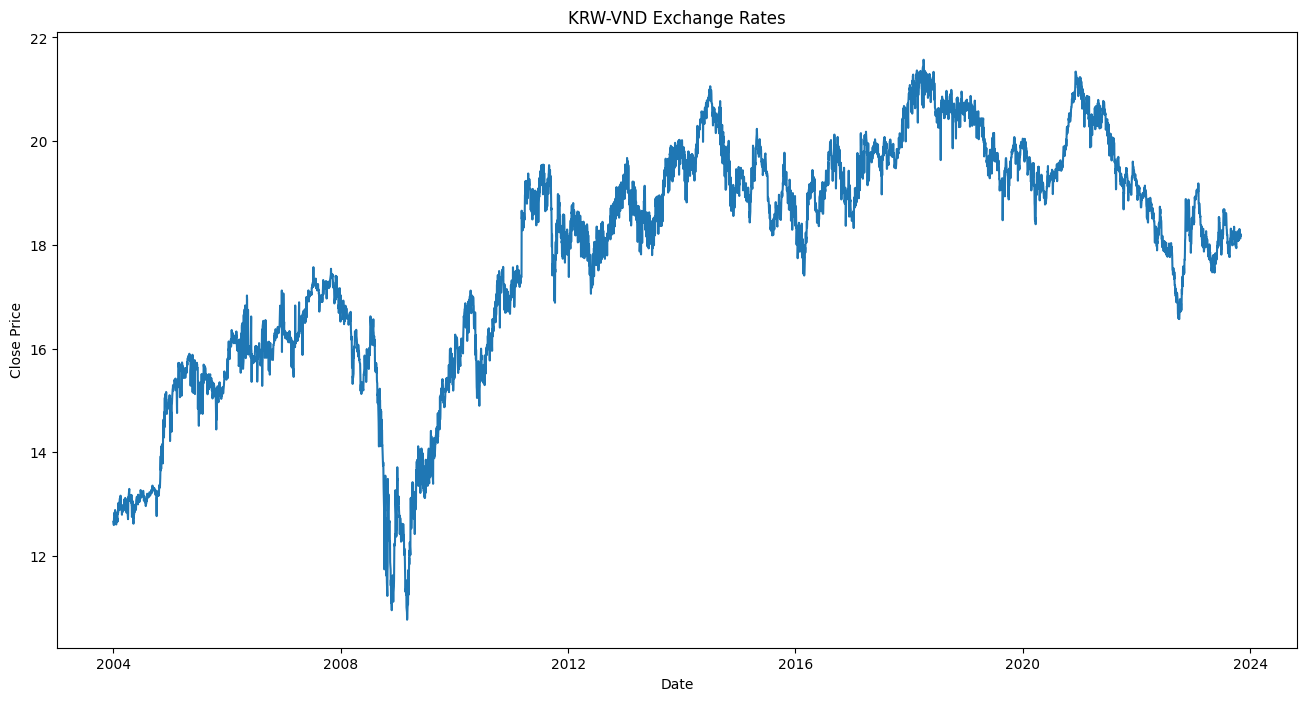

In [5]:
plt.figure(figsize=(16,8))
plt.plot(df)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("KRW-VND Exchange Rates")
plt.savefig('./plots/krwvnd_rates')
plt.show()

In [6]:
data = df.values
data = data.astype('float32')
data

array([[12.661377],
       [12.597076],
       [12.724485],
       ...,
       [18.123247],
       [18.211071],
       [18.17288 ]], dtype=float32)

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
data

array([[0.1749875 ],
       [0.16903287],
       [0.18083173],
       ...,
       [0.6807906 ],
       [0.68892366],
       [0.68538696]], dtype=float32)

In [8]:
train_size = int(len(data) * 0.8)
valid_size = len(data) - train_size
train, valid = data[0:train_size,:], data[train_size:len(data),:]
train.shape, valid.shape

((4783, 1), (1196, 1))

In [9]:
def create_dataset(dataset, context_length=1, prediction_length=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-context_length-prediction_length-1):
        dataX.append(dataset[i:i+context_length])
        dataY.append(dataset[i+context_length:i+context_length+prediction_length])
    return np.array(dataX), np.array(dataY)

In [10]:
context_len, prediction_len = 96, 30
trainX, trainY = create_dataset(train, context_len, prediction_len)
validX, validY = create_dataset(valid, context_len, prediction_len)

In [11]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))

In [12]:
trainX.shape, trainY.shape

((4656, 1, 96), (4656, 30, 1))

In [13]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, context_len)))
model.add(Dense(prediction_len))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)


Epoch 1/10

4656/4656 - 5s - loss: 0.0149 - 5s/epoch - 1ms/step
Epoch 2/10
4656/4656 - 4s - loss: 0.0024 - 4s/epoch - 819us/step
Epoch 3/10
4656/4656 - 4s - loss: 0.0023 - 4s/epoch - 803us/step
Epoch 4/10
4656/4656 - 4s - loss: 0.0022 - 4s/epoch - 812us/step
Epoch 5/10
4656/4656 - 4s - loss: 0.0022 - 4s/epoch - 838us/step
Epoch 6/10
4656/4656 - 4s - loss: 0.0021 - 4s/epoch - 821us/step
Epoch 7/10
4656/4656 - 4s - loss: 0.0021 - 4s/epoch - 833us/step
Epoch 8/10
4656/4656 - 4s - loss: 0.0021 - 4s/epoch - 822us/step
Epoch 9/10
4656/4656 - 4s - loss: 0.0021 - 4s/epoch - 828us/step
Epoch 10/10
4656/4656 - 4s - loss: 0.0021 - 4s/epoch - 818us/step


In [14]:
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)

trainY = np.reshape(trainY, (trainY.shape[0], trainY.shape[1]))
validY = np.reshape(validY, (validY.shape[0], validY.shape[1]))

trainScore = mean_squared_error(trainY[:,0], trainPredict[:,0])
print('Train Score: %.4f MSE' % (trainScore))
validScore = mean_squared_error(validY[:,0], validPredict[:,0])
print('Valid Score: %.4f MSE' % (validScore))

34/34 [==============================] - 0s 664us/step
Train Score: 0.0006 MSE
Valid Score: 0.0005 MSE


In [15]:
test_df = pd.read_csv("./krwvnd-test.csv")
test_df["Close"] = test_df.Close.map(lambda x: np.float32(x.replace(",", ".")))
test_df["Date"] = test_df.Date.map(lambda x: pd.to_datetime(x, dayfirst=True).date())
test_df = test_df.set_index("Date")
test_df.head()

,Close
Date,
2023-11-01,18.232344
2023-11-02,18.419567
2023-11-03,18.743101
2023-11-04,18.740891
2023-11-05,18.740891


In [16]:
testY = test_df.values
testY = testY.astype('float32')
testY.shape

(30, 1)

In [17]:
testX = df.values[-context_len:]
testX = testX.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
testX = scaler.fit_transform(testX)
testX = np.reshape(testX, (1, 1, testX.shape[0]))
testX.shape

(1, 1, 96)

In [18]:
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testPredict = np.reshape(testPredict, (testPredict.shape[1], testPredict.shape[0]))
testPredict.shape

1/1 [==============================] - 0s 18ms/step


(30, 1)

In [23]:
scaler.inverse_transform(testX.reshape(1, -1))

array([[18.607956, 18.604755, 18.607811, 18.530762, 18.372889, 18.310753,
        18.299738, 18.201128, 18.194862, 18.200989, 18.140816, 18.025541,
        18.061989, 18.00888 , 17.856606, 17.856617, 17.856472, 17.836565,
        17.904285, 17.820463, 17.81196 , 17.773996, 17.773874, 17.773865,
        17.76632 , 17.768042, 18.042599, 18.092686, 18.122314, 18.122314,
        18.122314, 18.201124, 18.313341, 18.224674, 18.168592, 18.267662,
        18.191954, 18.267525, 18.260748, 18.065742, 18.02964 , 17.990759,
        18.002934, 18.007153, 18.002798, 18.2071  , 18.180115, 18.1211  ,
        18.244658, 18.252459, 18.251507, 18.252321, 18.319199, 18.349695,
        18.21742 , 18.129446, 18.2476  , 18.24761 , 18.247532, 18.212704,
        18.005482, 18.023085, 18.089495, 17.964714, 17.968441, 17.96458 ,
        17.973646, 17.936651, 18.073826, 18.120785, 18.13881 , 18.13808 ,
        18.138742, 18.096544, 18.178099, 18.261822, 18.1502  , 18.07378 ,
        18.07378 , 18.073713, 18.15444

In [29]:
denormalized_data = scaler.inverse_transform(testX.reshape(1, -1))[0]
testPredict = testPredict.reshape(-1)
num_lookback = denormalized_data.shape[0]

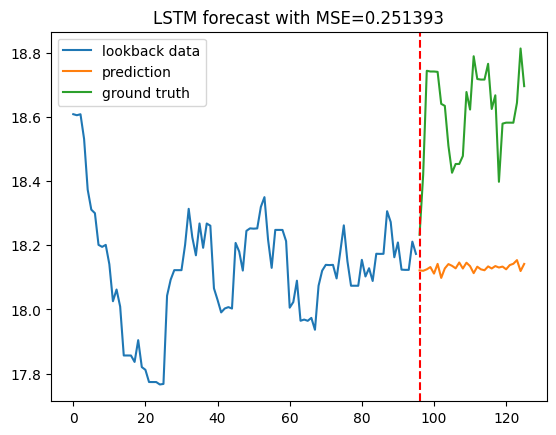

In [33]:
testScore = mean_squared_error(testY, testPredict)

plt.plot(denormalized_data, label="lookback data")
plt.plot(np.concatenate([np.ones(num_lookback) * np.nan, testPredict.reshape(-1)]), label='prediction')
plt.plot(np.concatenate([np.ones(num_lookback) * np.nan, testY.reshape(-1)]), label='ground truth')
plt.axvline(x=denormalized_data.shape[0], c='r', linestyle='--')
plt.title(f"LSTM forecast with MSE={testScore:.6f}")
plt.legend()
plt.savefig('./plots/lstm_krwkzt_test')
plt.show()